<a href="https://colab.research.google.com/github/electrolabopen/objectexamples/blob/main/transferlearningClassificadorMobilenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Crear las carpetas para subir las imagenes

!mkdir chihuahua

In [4]:
#Entramos en la carpeta y descomprimimos el archivo

%cd chihuahua

!unzip chihuahua.zip
%cd ..


#Si quiero agregar mas clases simplmente subo los archivos .zip

/content/chihuahua
Archive:  chihuahua.zip
   creating: chihuahua/
  inflating: chihuahua/1013503.jpg   
  inflating: chihuahua/chihuahua-1393442_960_720.jpg  
  inflating: chihuahua/chihuahua-6601466_960_720.jpg  
  inflating: chihuahua/chihuahua-981188_1920-1024x681.jpg  
  inflating: chihuahua/CHIHUAHUA-EN-ALFOMBRA.jpg  
 extracting: chihuahua/cuanto-tiempo-vive-un-chihuahua.jpg  
  inflating: chihuahua/derramamiento-de-chihuahua-cuanto-derraman-los-chihuahuas_61002349d3c18.jpeg  
  inflating: chihuahua/ficha-chihuahua-ok.jpeg  
  inflating: chihuahua/image11.jpeg  
  inflating: chihuahua/image12.jpeg  
  inflating: chihuahua/image13.jpeg  
  inflating: chihuahua/image14.jpeg  
  inflating: chihuahua/image15.jpeg  
  inflating: chihuahua/image16.jpeg  
  inflating: chihuahua/image17.jpeg  
  inflating: chihuahua/image18.jpeg  
  inflating: chihuahua/image19.jpeg  
  inflating: chihuahua/image2.jpeg   
  inflating: chihuahua/image20.jpeg  
  inflating: chihuahua/image21.jpeg  
  infl

In [5]:
#Borrar los archivos .zip para no ocupar mucho la memoria ram del colab

!rm -rf /content/chihuahua/chihuahua.zip

In [6]:
#Mostrar cuantas imagenes tiene cada clase

!ls /content/chihuahua/chihuahua | wc -l #134

134


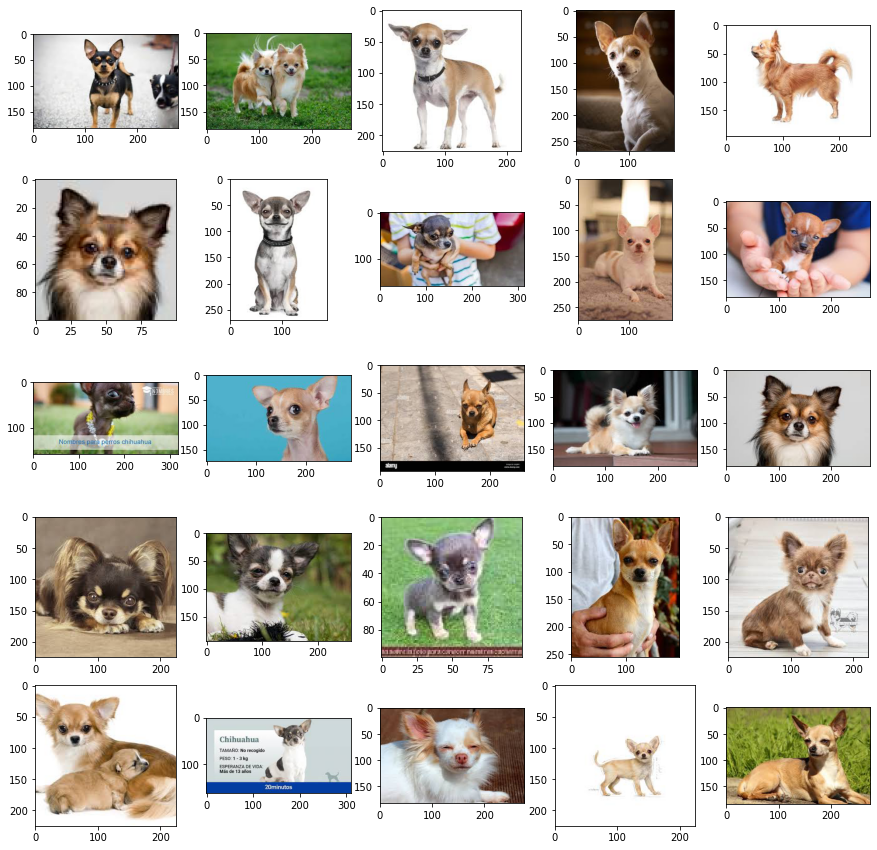

In [7]:
#Mostrar algunas imagenes con pyplot
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(15,15))

carpeta = '/content/chihuahua/chihuahua'
imagenes = os.listdir(carpeta)

for i, nombreimg in enumerate(imagenes[:25]):
  plt.subplot(5,5,i+1)
  imagen = mpimg.imread(carpeta + '/' + nombreimg)
  plt.imshow(imagen)

In [8]:
#Crear carpetas para hacer el set de datos

!mkdir dataset
!mkdir dataset/chihuahua

In [10]:
#Copiar imagenes que subimos a carpetas del dataset
#Limitar para que todos tengan la misma cantidad de imagenes
#maximo 419 (el num. menor de imagenes que subi)

import shutil
carpeta_fuente = '/content/chihuahua/chihuahua'
carpeta_destino = '/content/dataset/chihuahua'

imagenes = os.listdir(carpeta_fuente)

for i, nombreimg in enumerate(imagenes):
  if i < 419:
    #Copia de la carpeta fuente a la destino
    shutil.copy(carpeta_fuente + '/' + nombreimg, carpeta_destino + '/' + nombreimg)

In [ ]:
#Lo hago con todas las clases que tenga

"""
carpeta_fuente = '/content/tenedores'
carpeta_destino = '/content/dataset/tenedor'

imagenes = os.listdir(carpeta_fuente)

for i, nombreimg in enumerate(imagenes):
  if i < 419:
    #Copia de la carpeta fuente a la destino
    shutil.copy(carpeta_fuente + '/' + nombreimg, carpeta_destino + '/' + nombreimg)"""

In [12]:
#Mostrar cuantas imagenes tengo de cada categoria en el dataset
#!ls /content/dataset/cuchara | wc -l
#!ls /content/dataset/cuchillo | wc -l
#!ls /content/dataset/tenedor | wc -l

Found 108 images belonging to 1 classes.
Found 26 images belonging to 1 classes.


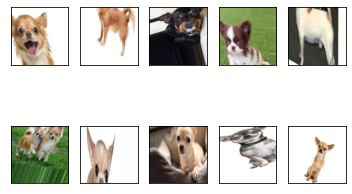

In [13]:
#Aumento de datos con ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

#Crear el dataset generador
datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 30,
    width_shift_range = 0.25,
    height_shift_range = 0.25,
    shear_range = 15,
    zoom_range = [0.5, 1.5],
    validation_split=0.2 #20% para pruebas
)

#Generadores para sets de entrenamiento y pruebas
data_gen_entrenamiento = datagen.flow_from_directory('/content/dataset', target_size=(224,224),
                                                     batch_size=32, shuffle=True, subset='training')
data_gen_pruebas = datagen.flow_from_directory('/content/dataset', target_size=(224,224),
                                                     batch_size=32, shuffle=True, subset='validation')

#Imprimir 10 imagenes del generador de entrenamiento
for imagen, etiqueta in data_gen_entrenamiento:
  for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(imagen[i])
  break
plt.show()


In [14]:
#Descargo el modelo para hacer transfer learning desde tensorflow hub

import tensorflow as tf
import tensorflow_hub as hub

url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
mobilenetv2 = hub.KerasLayer(url, input_shape=(224,224,3))

In [15]:
#Congelar el modelo descargado
mobilenetv2.trainable = False

In [16]:
#Aqui cambio el numero de clases que voy a clasificar
modelo = tf.keras.Sequential([
    mobilenetv2,
    tf.keras.layers.Dense(1, activation='softmax')
])

In [17]:
modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [18]:
#Compilar como siempre
modelo.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [19]:
#Entrenar el modelo aqui lo puedo hacer por mas epocas
EPOCAS = 50

historial = modelo.fit(
    data_gen_entrenamiento, epochs=EPOCAS, batch_size=32,
    validation_data=data_gen_pruebas
)

Epoch 1/50
4/4 [==============================] - 15s 803ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/50
4/4 [==============================] - 2s 404ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/50
4/4 [==============================] - 2s 408ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/50
4/4 [==============================] - 2s 407ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/50
4/4 [==============================] - 2s 402ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/50
4/4 [==============================] - 2s 480ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/50
4/4 [==============================] - 2s 409ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_los

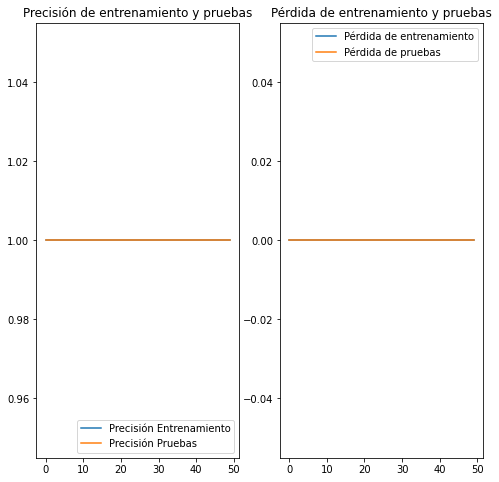

In [20]:
#Graficas de precisión
acc = historial.history['accuracy']
val_acc = historial.history['val_accuracy']

loss = historial.history['loss']
val_loss = historial.history['val_loss']

rango_epocas = range(50)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(rango_epocas, acc, label='Precisión Entrenamiento')
plt.plot(rango_epocas, val_acc, label='Precisión Pruebas')
plt.legend(loc='lower right')
plt.title('Precisión de entrenamiento y pruebas')

plt.subplot(1,2,2)
plt.plot(rango_epocas, loss, label='Pérdida de entrenamiento')
plt.plot(rango_epocas, val_loss, label='Pérdida de pruebas')
plt.legend(loc='upper right')
plt.title('Pérdida de entrenamiento y pruebas')
plt.show()

In [21]:
#Categorizar una imagen de internet
from PIL import Image
import requests
from io import BytesIO
import cv2

def categorizar(url):
  respuesta = requests.get(url)
  img = Image.open(BytesIO(respuesta.content))
  img = np.array(img).astype(float)/255

  img = cv2.resize(img, (224,224))
  prediccion = modelo.predict(img.reshape(-1, 224, 224, 3))
  return np.argmax(prediccion[0], axis=-1)

In [22]:
#0 = chihuahua, 1 = , 2 = 
url = 'https://th.bing.com/th/id/OIP.chUVuW8eg5iO_uPtXN1UZgHaFN?w=277&h=194&c=7&r=0&o=5&dpr=1.25&pid=1.7' #debe ser 2
prediccion = categorizar (url)
print(prediccion)

0


In [23]:
#Crear la carpeta para exportarla a TF Serving
!mkdir -p carpeta_salida/modelo_perros/1

In [24]:
#Guardar el modelo en formato SavedModel
modelo.save('carpeta_salida/modelo_perros/1')

INFO:tensorflow:Assets written to: carpeta_salida/modelo_perros/1/assets


INFO:tensorflow:Assets written to: carpeta_salida/modelo_perros/1/assets


In [25]:
#Hacerlo un zip para bajarlo y usarlo en otro lado
!zip -r modelo_cocina.zip /content/carpeta_salida/modelo_perros/

  adding: content/carpeta_salida/modelo_perros/ (stored 0%)
  adding: content/carpeta_salida/modelo_perros/1/ (stored 0%)
  adding: content/carpeta_salida/modelo_perros/1/saved_model.pb (deflated 92%)
  adding: content/carpeta_salida/modelo_perros/1/assets/ (stored 0%)
  adding: content/carpeta_salida/modelo_perros/1/variables/ (stored 0%)
  adding: content/carpeta_salida/modelo_perros/1/variables/variables.index (deflated 78%)
  adding: content/carpeta_salida/modelo_perros/1/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/carpeta_salida/modelo_perros/1/keras_metadata.pb (deflated 80%)
